In [1]:
import pathlib
list(pathlib.Path(r'C:\Program Files\Micro-Manager-nightly-markt').glob('*.cfg'))

[WindowsPath('C:/Program Files/Micro-Manager-nightly-markt/DCC_alone.cfg'),
 WindowsPath('C:/Program Files/Micro-Manager-nightly-markt/ImageJ.cfg'),
 WindowsPath('C:/Program Files/Micro-Manager-nightly-markt/MMConfig_demo.cfg'),
 WindowsPath('C:/Program Files/Micro-Manager-nightly-markt/test-dcc.cfg')]

In [2]:
#!cmd
#export MICROMANAGER_PATH=/path/to/installation
#mmcore use <some path or pattern>

## do only once for pymmcore-plus sanity tests

In [9]:
! mmcore --version

pymmcore-plus v0.13.7
pymmcore v11.5.0.73.0
MMCore vMMCore version 11.5.0
Device API version 73, Module API version 10


In [10]:
! mmcore list

ðŸ“� C:\Program Files
   * Micro-Manager-1.4 (active)


In [14]:
! mmcore use "C:\Program Files\Micro-Manager-nightly-markt"

using C:\Program Files\Micro-Manager-nightly-markt


In [12]:
! mmcore list

ðŸ“� C:\Program Files
   * Micro-Manager-nightly-markt (Dev. Interface 73) (active)
   â€¢ Micro-Manager-1.4


In [13]:
from pymmcore_plus import find_micromanager
print(find_micromanager())

C:\Program Files\Micro-Manager-nightly-markt


## start here: dcc load

In [3]:
from pymmcore_plus import CMMCorePlus
mmc = CMMCorePlus()
#mmc.loadSystemConfiguration(r'C:/Program Files/Micro-Manager-2.0.0/DCC_alone.cfg')
mmc.loadSystemConfiguration(r'C:/Program Files/Micro-Manager-nightly-markt/DCC_alone.cfg')

In [5]:
print(mmc.getLoadedDevices())
for dev in mmc.getLoadedDevices():
    print(dev, mmc.getDevicePropertyNames(dev))

('DCCHub', 'DCCModule1', 'Core')
DCCHub ('SimulateDevice', 'Simulated', 'UseModule1', 'UseModule2', 'UseModule3', 'UseModule4', 'UseModule5', 'UseModule6', 'UseModule7', 'UseModule8')
DCCModule1 ('BaseAddress', 'BusNumber', 'C1_GainHV', 'C1_Minus5V', 'C1_Overloaded', 'C1_Plus12V', 'C1_Plus5V', 'C2_DigitalOut', 'C2_Minus5V', 'C2_Plus12V', 'C2_Plus5V', 'C3_CoolerCurrentLimit', 'C3_CoolerCurrentLimitReached', 'C3_CoolerVoltage', 'C3_Cooling', 'C3_GainHV', 'C3_Minus5V', 'C3_Overloaded', 'C3_Plus12V', 'C3_Plus5V', 'ClearOverloads', 'EnableOutputs', 'ModuleNumber', 'ModuleType', 'SerialNumber', 'SlotNumber')
Core ('AutoFocus', 'AutoShutter', 'Camera', 'ChannelGroup', 'Focus', 'Galvo', 'ImageProcessor', 'Initialize', 'SLM', 'Shutter', 'TimeoutMs', 'XYStage')


In [6]:
mmc.getAvailableConfigGroups()

('ENABLE', 'GAIN CONTROL PERCENT', 'Supply')

In [7]:
device_adapter_names = mmc.getDeviceAdapterNames()
[k for k in device_adapter_names if k.find('BH')>-1]

['BH_DCC', 'BH_DCC_DCU']

In [8]:
from pymmcore_plus import Device, DeviceProperty

In [9]:
device = mmc.getDeviceObject('DCCHub')
device.load('BH_DCC_DCU', 'DCCHub') 
#device.initialize()
for prop in device.properties:
    print(prop.name, prop.value) 

SimulateDevice No
Simulated No
UseModule1 Yes
UseModule2 No
UseModule3 No
UseModule4 No
UseModule5 No
UseModule6 No
UseModule7 No
UseModule8 No


C:\Users\lociuser\code\timetagger-scripts\.venv\Lib\site-packages\pymmcore_plus\core\_mmcore_plus.py:383: UserWarning: The specified device label "DCCHub" is already in use. Device 'DCCHub' appears to be loaded already.
  if exc := self._load_error_with_info(label, moduleName, deviceName, str(e)):


In [10]:
props = mmc.getDevicePropertyNames('DCCModule1')
for prop in props:
    print(prop) 

BaseAddress
BusNumber
C1_GainHV
C1_Minus5V
C1_Overloaded
C1_Plus12V
C1_Plus5V
C2_DigitalOut
C2_Minus5V
C2_Plus12V
C2_Plus5V
C3_CoolerCurrentLimit
C3_CoolerCurrentLimitReached
C3_CoolerVoltage
C3_Cooling
C3_GainHV
C3_Minus5V
C3_Overloaded
C3_Plus12V
C3_Plus5V
ClearOverloads
EnableOutputs
ModuleNumber
ModuleType
SerialNumber
SlotNumber


In [12]:
mmc.getProperty('DCCModule1', 'C3_CoolerVoltage'), mmc.getProperty('DCCModule1','C3_Cooling'),mmc.getProperty('DCCModule1','C3_CoolerCurrentLimit')

('0.0000', 'Off', '0.0000')

In [11]:
mmc.getProperty('DCCModule1', 'C1_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V')

('0.0000', 'Off', 'Off')

In [13]:
def start_PMT(mmc,gain=65,ch='C3'):
    mmc.setProperty('DCCModule1',ch+'_GainHV',gain)
    mmc.setProperty('DCCModule1','EnableOutputs','On')
    mmc.setProperty('DCCModule1',ch+'_Plus12V','On')
    mmc.waitForDevice('DCCModule1')

def stop_PMT(mmc,gain=0,ch='C3'):
    mmc.setProperty('DCCModule1',ch+'_GainHV',gain)
    mmc.setProperty('DCCModule1','EnableOutputs','Off')
    mmc.setProperty('DCCModule1',ch+'_Plus12V','Off')
    mmc.waitForDevice('DCCModule1')

def pmt_cooler(mmc):
    mmc.setProperty('DCCModule1', 'C3_CoolerVoltage',2.6) 
    mmc.setProperty('DCCModule1','C3_Cooling','On')
    mmc.setProperty('DCCModule1','C3_CoolerCurrentLimit',1.0)


In [35]:
from dataclasses import dataclass, asdict
from typing import Optional

@dataclass
class PMTChannelConfig:
    module: str = "DCCModule1"
    channel: str = "C3"
    gain_hv: float = 65.0
    enable_outputs: bool = True
    plus12v: bool = True
    cooler_voltage: Optional[float] = None
    cooler_on: bool = False
    cooler_current_limit: Optional[float] = None

    def apply(self, mmc):
        """Write this config into the MMCore device."""
        ch = self.channel
        m = self.module

        mmc.setProperty(m, f"{ch}_GainHV",      self.gain_hv)
        mmc.setProperty(m, "EnableOutputs",     "On" if self.enable_outputs else "Off")
        mmc.setProperty(m, f"{ch}_Plus12V",      "On" if self.plus12v       else "Off")

        if self.cooler_voltage is not None:
            mmc.setProperty(m, f"{ch}_CoolerVoltage", self.cooler_voltage)
        if self.cooler_on:
            mmc.setProperty(m, f"{ch}_Cooling",       "On")
        if self.cooler_current_limit is not None:
            mmc.setProperty(m, f"{ch}_CoolerCurrentLimit", self.cooler_current_limit)

        mmc.waitForDevice(m)

    def snapshot(self, mmc):
        """Read back every property into a dict."""
        ch = self.channel
        m  = self.module

        data = {
            "gain_hv":           float(mmc.getProperty(m, f"{ch}_GainHV")),
            "enable_outputs":    mmc.getProperty(m, "EnableOutputs") == "On",
            "plus12v":           mmc.getProperty(m, f"{ch}_Plus12V") == "On",
            "cooler_voltage":    float(mmc.getProperty(m, f"{ch}_CoolerVoltage")),
            "cooler_on":         mmc.getProperty(m, f"{ch}_Cooling") == "On",
            "cooler_current_limit": float(mmc.getProperty(m, f"{ch}_CoolerCurrentLimit")),
        }
        return data

    def set_gain(self, mmc, gain_hv: float):
        """Change only the high‑voltage gain (in %)."""
        self.gain_hv = gain_hv
        mmc.setProperty(self.module, f"{self.channel}_GainHV", gain_hv)
        mmc.waitForDevice(self.module)

    def turn_off_cooling(self, mmc):
        """Disable the cooler on this channel."""
        self.cooler_on = False
        mmc.setProperty(self.module, f"{self.channel}_Cooling", "Off")
        mmc.waitForDevice(self.module)

    def turn_off_pmt(self, mmc):
        """
        Fully power down the PMT channel:
         - set gain to 0%
         - outputs OFF
         - +12 V OFF
         - cooler OFF
        """
        m, ch = self.module, self.channel
        self.gain_hv = 0.0
        self.enable_outputs = False
        self.plus12v = False
        self.cooler_on = False

        mmc.setProperty(m, f"{ch}_GainHV",      0.0)
        mmc.setProperty(m, "EnableOutputs",     "Off")
        mmc.setProperty(m, f"{ch}_Plus12V",      "Off")
        mmc.setProperty(m, f"{ch}_Cooling",      "Off")
        mmc.waitForDevice(m)

    def destroy(self, mmc):
        self.turn_off_pmt(mmc)
        
import time
def sweep_gain(mmc, config: PMTChannelConfig,
               start: int=45, stop: int=85, step: int=5, sleep_sec = 2):
    
    for g in range(start, stop+1, step):
        config.set_gain(mmc, g)
        #results[g] = config.snapshot(mmc)
        print(config.snapshot(mmc)['gain_hv'])
        time.sleep(sleep_sec)

In [25]:
cfg = PMTChannelConfig(
    module="DCCModule1", channel="C3",
    gain_hv=70, enable_outputs=True, plus12v=True,
    cooler_voltage=2.6, cooler_on=True, cooler_current_limit=1.0
)
cfg

PMTChannelConfig(module='DCCModule1', channel='C3', gain_hv=70, enable_outputs=True, plus12v=True, cooler_voltage=2.6, cooler_on=True, cooler_current_limit=1.0)

In [26]:
cfg.apply(mmc)
status = cfg.snapshot(mmc)
print("PMT status:", status)


PMT status: {'gain_hv': 70.0, 'enable_outputs': True, 'plus12v': True, 'cooler_voltage': 2.6, 'cooler_on': True, 'cooler_current_limit': 1.0}


In [27]:
cfg.apply(mmc)
status = cfg.snapshot(mmc)
print("PMT status:", status)


PMT status: {'gain_hv': 70.0, 'enable_outputs': True, 'plus12v': True, 'cooler_voltage': 2.6, 'cooler_on': True, 'cooler_current_limit': 1.0}


In [28]:
cfg.gain_hv, cfg.enable_outputs

(70, True)

In [36]:
sweep_gain(mmc,cfg)

45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0


In [39]:
cfg.turn_off_pmt(mmc)

In [ ]:
from TimeTagger import TimeTagger, HistogramLogBins
tagger = TimeTagger.createTimeTagger()
# click_channel is your PMT channel, start_channel can be unused or your sync
cfg.apply()
hist = HistogramLogBins(tagger,
                       click_channel=-1,
                       start_channel=1,   # or your laser‑sync channel
                       exp_start=100,      # bin width in ps
                       n_bins=100) 
#classHistogramLogBins(tagger, click_channel, start_channel, exp_start, ex_stop, n_bins, click_gate=None, start_gate=None)
cfg.turn_off_pmt()

In [74]:

start_PMT(mmc)
print(mmc.getProperty('DCCModule1', 'C3_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V'))
stop_PMT(mmc)
print(mmc.getProperty('DCCModule1', 'C3_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V'))

65.0000 On On
0.0000 Off Off


## time tagger

In [59]:
from pymmcore_plus import CMMCorePlus
mmc = CMMCorePlus()
#mmc.loadSystemConfiguration(r'C:/Program Files/Micro-Manager-2.0.0/DCC_alone.cfg')
mmc.loadSystemConfiguration(r'C:/Program Files/Micro-Manager-nightly-markt/DCC_alone.cfg')

In [51]:
print(mmc.getLoadedDevices())
for dev in core.getLoadedDevices():
    print(dev, core.getDevicePropertyNames(dev))

('DCCHub', 'DCCModule1', 'Core')
Core ('AutoFocus', 'AutoShutter', 'Camera', 'ChannelGroup', 'Focus', 'Galvo', 'ImageProcessor', 'Initialize', 'SLM', 'Shutter', 'TimeoutMs', 'XYStage')


In [18]:
mmc.getAvailableConfigGroups()

('ENABLE', 'GAIN CONTROL PERCENT', 'Supply')

In [27]:
device_adapter_names = mmc.getDeviceAdapterNames()
[k for k in device_adapter_names if k.find('BH')>-1]

['BH_DCC', 'BH_DCC_DCU']

In [33]:
from pymmcore_plus import Device, DeviceProperty

In [38]:
device = mmc.getDeviceObject('DCCHub')
device.load('BH_DCC_DCU', 'DCCHub') 
#device.initialize()
for prop in device.properties:
    print(prop.name, prop.value) 

SimulateDevice No
Simulated No
UseModule1 Yes
UseModule2 No
UseModule3 No
UseModule4 No
UseModule5 No
UseModule6 No
UseModule7 No
UseModule8 No


In [55]:
props = mmc.getDevicePropertyNames('DCCModule1')
for prop in props:
    print(prop) 

BaseAddress
BusNumber
C1_GainHV
C1_Minus5V
C1_Overloaded
C1_Plus12V
C1_Plus5V
C2_DigitalOut
C2_Minus5V
C2_Plus12V
C2_Plus5V
C3_CoolerCurrentLimit
C3_CoolerCurrentLimitReached
C3_CoolerVoltage
C3_Cooling
C3_GainHV
C3_Minus5V
C3_Overloaded
C3_Plus12V
C3_Plus5V
ClearOverloads
EnableOutputs
ModuleNumber
ModuleType
SerialNumber
SlotNumber


In [57]:
mmc.getProperty('DCCModule1', 'C1_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V')

('0.0000', 'Off', 'Off')

In [73]:
def start_PMT(mmc,gain=65,ch='C3'):
    mmc.setProperty('DCCModule1',ch+'_GainHV',gain)
    mmc.setProperty('DCCModule1','EnableOutputs','On')
    mmc.setProperty('DCCModule1',ch+'_Plus12V','On')
    mmc.waitForDevice('DCCModule1')

def stop_PMT(mmc,gain=0,ch='C3'):
    mmc.setProperty('DCCModule1',ch+'_GainHV',gain)
    mmc.setProperty('DCCModule1','EnableOutputs','Off')
    mmc.setProperty('DCCModule1',ch+'_Plus12V','Off')
    mmc.waitForDevice('DCCModule1')


In [74]:

start_PMT(mmc)
print(mmc.getProperty('DCCModule1', 'C3_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V'))
stop_PMT(mmc)
print(mmc.getProperty('DCCModule1', 'C3_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V'))

65.0000 On On
0.0000 Off Off


## time tagger (duplicate?)

In [59]:
import TimeTagger as TT
from TimeTagger import Countrate, Counter

In [60]:
tagger = TT.createTimeTagger()
tagger.reset()
tagger.clearOverflows()


In [61]:
''' set variables and triggers ''' 

# input channels
pmt1_start = -1
pmt1_stop = 1

# trigger levels in V
tagger.setTriggerLevel(pmt1_start,-0.01)  


In [62]:
channels = [pmt1_start,pmt1_stop]

In [63]:
import matplotlib.pyplot as plt

In [64]:
import numpy as np

In [65]:
binwidth = 1E9
n_values = 5000
binwidth*n_values/1E12

5.0

In [66]:
import time

In [80]:
start_PMT(mmc)

5.0 sec


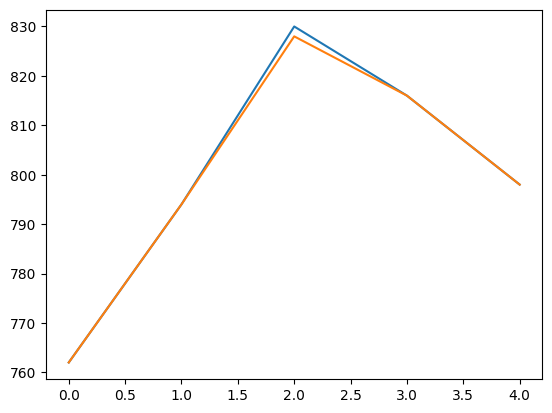

In [81]:
binwidth = 1000E9     # in ms
n_values = 5  # 
counter = Counter(tagger, channels, binwidth, n_values) 
counter.startFor(capture_duration=binwidth*n_values)
print(binwidth*n_values/1E12,'sec')
while counter.isRunning(): time.sleep(binwidth*n_values/1E12)
if not counter.isRunning():
    data = counter.getData()
    plt. plot(data.T,marker='.')

In [84]:
data,channels

(array([[762, 794, 830, 816, 798],
        [762, 794, 828, 816, 798]], dtype=int32),
 [-1, 1])

In [82]:
stop_PMT(mmc)

In [85]:
counter.getConfiguration()

{'name': 'Counter',
 'params': {'binwidth': 1000000000000, 'channels': [-1, 1], 'n values': 5},
 'registered channels': [-1, 1],
 'virtual channels': []}

In [86]:
channels

[-1, 1]

In [105]:
def get_darkcounts(collection_time_sec = 5, timing_resolution_sec=1):
    start_PMT(mmc)
    binwidth = timing_resolution_sec * 1E12     # in ms
    n_values = collection_time_sec/timing_resolution_sec  # 
    counter = Counter(tagger, channels, binwidth, n_values) 
    counter.startFor(capture_duration=binwidth*n_values)
    print("Collection time =",binwidth*n_values/1E12,'sec')
    while counter.isRunning(): time.sleep(binwidth*n_values/1E12)
    if not counter.isRunning():
        data = counter.getData()
    stop_PMT(mmc)
    return data

In [106]:
data =get_darkcounts(collection_time_sec=7,timing_resolution_sec=.1)

7.0 sec


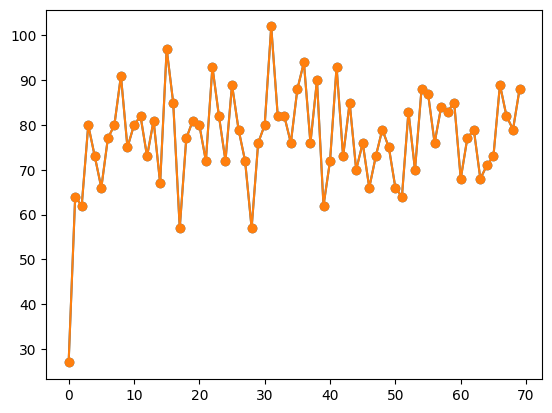

In [107]:
plt.plot(data.T,marker = 'o')

## plot logans data

In [44]:
import pandas as pd
import os
import pathlib
from pathlib import Path as WindowsPath
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 2677-08A1

 Directory of c:\Users\lociuser\code\timetagger-scripts

04/19/2025  10:50 AM    <DIR>          .
04/19/2025  10:50 AM    <DIR>          ..
04/19/2025  04:24 AM               172 .gitignore
04/19/2025  10:32 AM    <DIR>          .ipynb_checkpoints
04/18/2025  04:04 PM    <DIR>          .venv
04/21/2025  04:55 PM    <DIR>          data
04/19/2025  04:00 AM           118,412 plot_time_trace.ipynb
04/19/2025  03:14 AM             2,770 plot_time_trace.py
04/19/2025  03:14 AM             4,363 plot_time_trace_mock.py
04/19/2025  12:23 PM    <DIR>          pmt_profiler
04/19/2025  03:17 AM    <DIR>          pmt_profiler.egg-info
04/19/2025  04:24 AM               903 pyproject.toml
04/19/2025  03:14 AM             1,715 README.md
04/19/2025  10:50 AM             2,701 Read_tekMDO32_data.ipynb
04/19/2025  03:14 AM               114 requirements.txt
04/18/2025  03:54 PM    <DIR>          swabianinstruments-web-demo
04/18/2025  03:52

In [5]:
list(pathlib.Path('data').glob('*.csv'))

[WindowsPath('data/dark_counts_20250419_042519.csv'),
 WindowsPath('data/dark_counts_20250419_042847.csv'),
 WindowsPath('data/dark_counts_20250419_044344.csv'),
 WindowsPath('data/dark_counts_20250419_044611.csv'),
 WindowsPath('data/dark_counts_20250419_044842.csv'),
 WindowsPath('data/dark_counts_20250419_045351.csv'),
 WindowsPath('data/dark_counts_20250419_110138.csv'),
 WindowsPath('data/dark_counts_20250419_110247.csv'),
 WindowsPath('data/dark_counts_20250419_110926_ctime_0.csv'),
 WindowsPath('data/dark_counts_20250419_111054_ctime_0.csv'),
 WindowsPath('data/dark_counts_20250419_111115_ctime_10.csv'),
 WindowsPath('data/dark_counts_20250421_160321_ctime_0.csv'),
 WindowsPath('data/dark_counts_20250421_160552_ctime_30.csv'),
 WindowsPath('data/dark_counts_20250421_161046_ctime_0_AP-SLIM-X-2012.csv'),
 WindowsPath('data/dark_counts_20250421_161257_ctime_30_AP-SLIM-X-2012.csv'),
 WindowsPath('data/dark_counts_20250421_163315_ctime_0.csv'),
 WindowsPath('data/dark_counts_20250421

dark_counts_20250421_161046_ctime_0_AP-SLIM-X-2012.csv (100, 3)


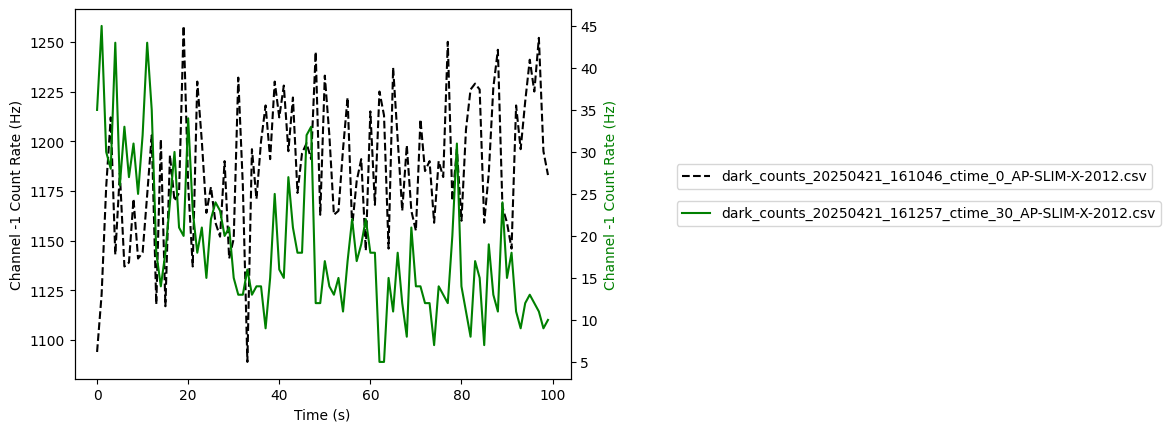

In [43]:

for i,j in [#[WindowsPath('data/dark_counts_20250421_160321_ctime_0.csv'),            WindowsPath('data/dark_counts_20250421_160552_ctime_30.csv')],
            [WindowsPath('data/dark_counts_20250421_161046_ctime_0_AP-SLIM-X-2012.csv'),            WindowsPath('data/dark_counts_20250421_161257_ctime_30_AP-SLIM-X-2012.csv')],
           # [WindowsPath('data/dark_counts_20250421_163315_ctime_0.csv'),            WindowsPath('data/dark_counts_20250421_163527_ctime_30.csv')],
           # [WindowsPath('data/dark_counts_20250421_164649_ctime_0.csv'),            WindowsPath('data/dark_counts_20250421_164820_ctime_30.csv')]
        ]:
    _,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    df1 = pd.read_csv(i)
    df2 = pd.read_csv(j)
    sns.lineplot(x=df1.columns[0],y=df1.columns[1],data=df1,label = i.name, ax=ax1, linestyle='--',color='k')
    print(i.name, df.shape) 
    sns.lineplot(x=df2.columns[0],y=df2.columns[1],data=df2,label = j.name, ax=ax2, linestyle='solid',color='g')
    ax2.set_ylabel(df1.columns[1], color='g')  # y-axis label color
    ax1.legend(  bbox_to_anchor=(1.2, 0.6))
    ax2.legend(  bbox_to_anchor=(1.2, 0.5))
